# Edge of Stability Echo State Network

Ceni, A., & Gallicchio, C. (2023). Edge of stability echo state networks. arXiv preprint arXiv:2308.02902.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.activationsfunc import tanh
from reservoirpy.mat_gen import normal, bernoulli, uniform
from reservoirpy.node import Node
from reservoirpy.nodes import Ridge

import reservoirpy
reservoirpy.set_seed(260_418)
reservoirpy.verbosity(0)

0

## Authors abstract
Echo State Networks (ESNs) are time-series processing models working under the Echo State Property (ESP)
principle. The ESP is a notion of stability that imposes an asymptotic fading of the memory of the input. On
the other hand, the resulting inherent architectural bias of ESNs may lead to an excessive loss of information,
which in turn harms the performance in certain tasks with long short-term memory requirements. With the
goal of bringing together the fading memory property and the ability to retain as much memory as possible,
in this paper we introduce a new ESN architecture, called the Edge of Stability Echo State Network (ES2N).
The introduced ES2N model is based on defining the reservoir layer as a convex combination of a nonlinear
reservoir (as in the standard ESN), and a linear reservoir that implements an orthogonal transformation. We
provide a thorough mathematical analysis of the introduced model, proving that the whole eigenspectrum
of the Jacobian of the ES2N map can be contained in an annular neighbourhood of a complex circle of
controllable radius, and exploit this property to demonstrate that the ES2N’s forward dynamics evolves
close to the edge-of-chaos regime by design. Remarkably, our experimental analysis shows that the newly
introduced reservoir model is able to reach the theoretical maximum short-term memory capacity. At the
same time, in comparison to standard ESN, ES2N is shown to offer an excellent trade-off between memory
and nonlinearity, as well as a significant improvement of performance in autoregressive nonlinear modeling.

## Implementation of the $ES^2N$ model using *ReservoirPy*

This notebook is provided as a demo of custom node creation in ReservoirPy, by implementing the $ES^N$ reservoir model proposed in *Edge of stability echo state networks* by Andrea Ceni and Claudio Gallicchio.

- The original basic reservoir equation in a leaky echo state network (without noise and feedback) is the following:
$$x[t+1] = \alpha * \phi(\mathbf{W} \cdot x[t]
    + \mathbf{W}_{in} \cdot \mathbf{u}[t+1])
  + (1 - \alpha) * x[t]$$

Where $\alpha \in [0; 1]$ is the leak rate. A complete description of the reservoir equation can be found in [the documentation](https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.nodes.Reservoir.html).

- The $ES^2N$ model proposed in this paper has the following equation:
$$x[t+1] = \beta * \phi(
    \mathbf{W} \cdot x[t]
    + \mathbf{W}_{in} \cdot \mathbf{u}[t+1])
  + (1 - \beta) * \mathbf{O}x[t]$$

where $\mathbf{O}$ is a random orthogonal matrix, and $\beta \in [0; 1]$ is an hyper-parameter called *proximity*. While it has a similar position than in the Leaky Echo State Network, it serves a very different role.



In [2]:
# Random orthogonal matrix generation
# We generate a random matrix and we apply a QR factorization
def random_orthogonal(units, seed = None):
    D = uniform(units, units,
        sparsity_type = "dense",
        seed=seed,
    )
    Q, _ = np.linalg.qr(D)

    return Q


### Node creation

In [3]:
def forward(node, x):
    f = node.activation
    b = node.proximity
    state = node.state().T

    nonlinear = f(node.W @ state + node.Win @ x)
    orthogonal = node.O @ state

    out = b * nonlinear + (1 - b) * orthogonal
    return out.T

def initialize(
    node,
    x,
    y = None,
    sr = None,
    input_scaling = None,
    input_dim = None,
    seed = None,
):
    node.set_input_dim(x.shape[-1])
    node.set_output_dim(node.units)

    # W
    if node.params["W"] is None:
        W = normal(
            node.units, node.units,
            loc = 0.,
            scale = 1,
            sr = sr,
            connectivity = 1.,
            sparsity_type = "dense",
            seed = seed,
        )
        node.set_param("W", W)
    
    # Win
    if node.params["Win"] is None:
        Win = bernoulli(
            node.units,
            x.shape[-1],
            input_scaling = input_scaling,
            connectivity = 1.,
            sparsity_type = "dense",
            seed = seed,
        )
        node.set_param("Win", Win)
    
    # O
    if node.params["O"] is None:
        O = random_orthogonal(
            node.units,
            seed=seed,
        )
        node.set_param("O", O)


class ES2N(Node):
    def __init__(self,
        units = None,
        sr = 1.,            # ~ rho
        input_scaling = 1., # omega
        proximity = 0.5,    # beta
        activation = tanh,  # phi
        W = None,
        Win = None,
        O = None,
        input_dim = None,
        seed = None,
        name = None,
    ):
        super(ES2N, self).__init__(
            forward = forward,
            initializer = partial(
                initialize,
                sr = sr,
                input_scaling = input_scaling,
            ),
            params = {
                "W": W,
                "Win": Win,
                "O": O,
                "internal_state": None,
            },
            hypers = {
                "units": units,
                "sr": sr,
                "input_scaling": input_scaling,
                "proximity": proximity,
                "activation": activation,
                "input_dim": input_dim,
            },
            name = name,
        )

### Quick evaluation

In [4]:
from reservoirpy.nodes import Reservoir
es2n = ES2N(500)
readout = Ridge(ridge=1e-4)

model = es2n >> readout

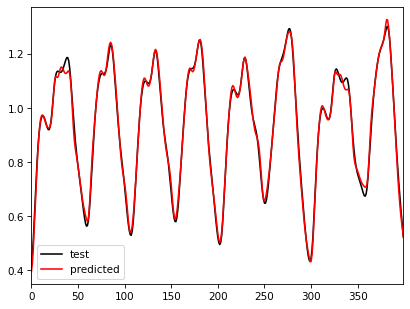

In [5]:
from reservoirpy.datasets import mackey_glass, to_forecasting

mg = mackey_glass(n_timesteps=2000, tau=17)
X_train, X_test, Y_train, Y_test = to_forecasting(mg, forecast=20, test_size=400)

model.fit(X_train, Y_train)

Y_pred = model.run(X_test)

plt.figure()
plt.plot(Y_test, color="black", label="test")
plt.plot(Y_pred, color="red", label="predicted")
plt.legend()
plt.show()

## Edge of chaos in $ES^2N$

This sections provides a mathematical analysis of the ES2N reservoir model.

In [6]:
# Computing the Jacobian matrix of the ES2N node

def D(es2n_node, u, x):
    kernel = es2n_node.W @ x.T + es2n_node.Win * u
    # Assuming the activation function phi is tanh
    # Its derivative is 1 - tanh^2
    return np.diagflat(1 - np.tanh(kernel)**2)

def jacobian(es2n_node, u, x):
    beta = es2n_node.proximity
    D_u_x = D(es2n_node, u, x)
    return beta * D_u_x @ es2n_node.W + (1 - beta) * es2n_node.O


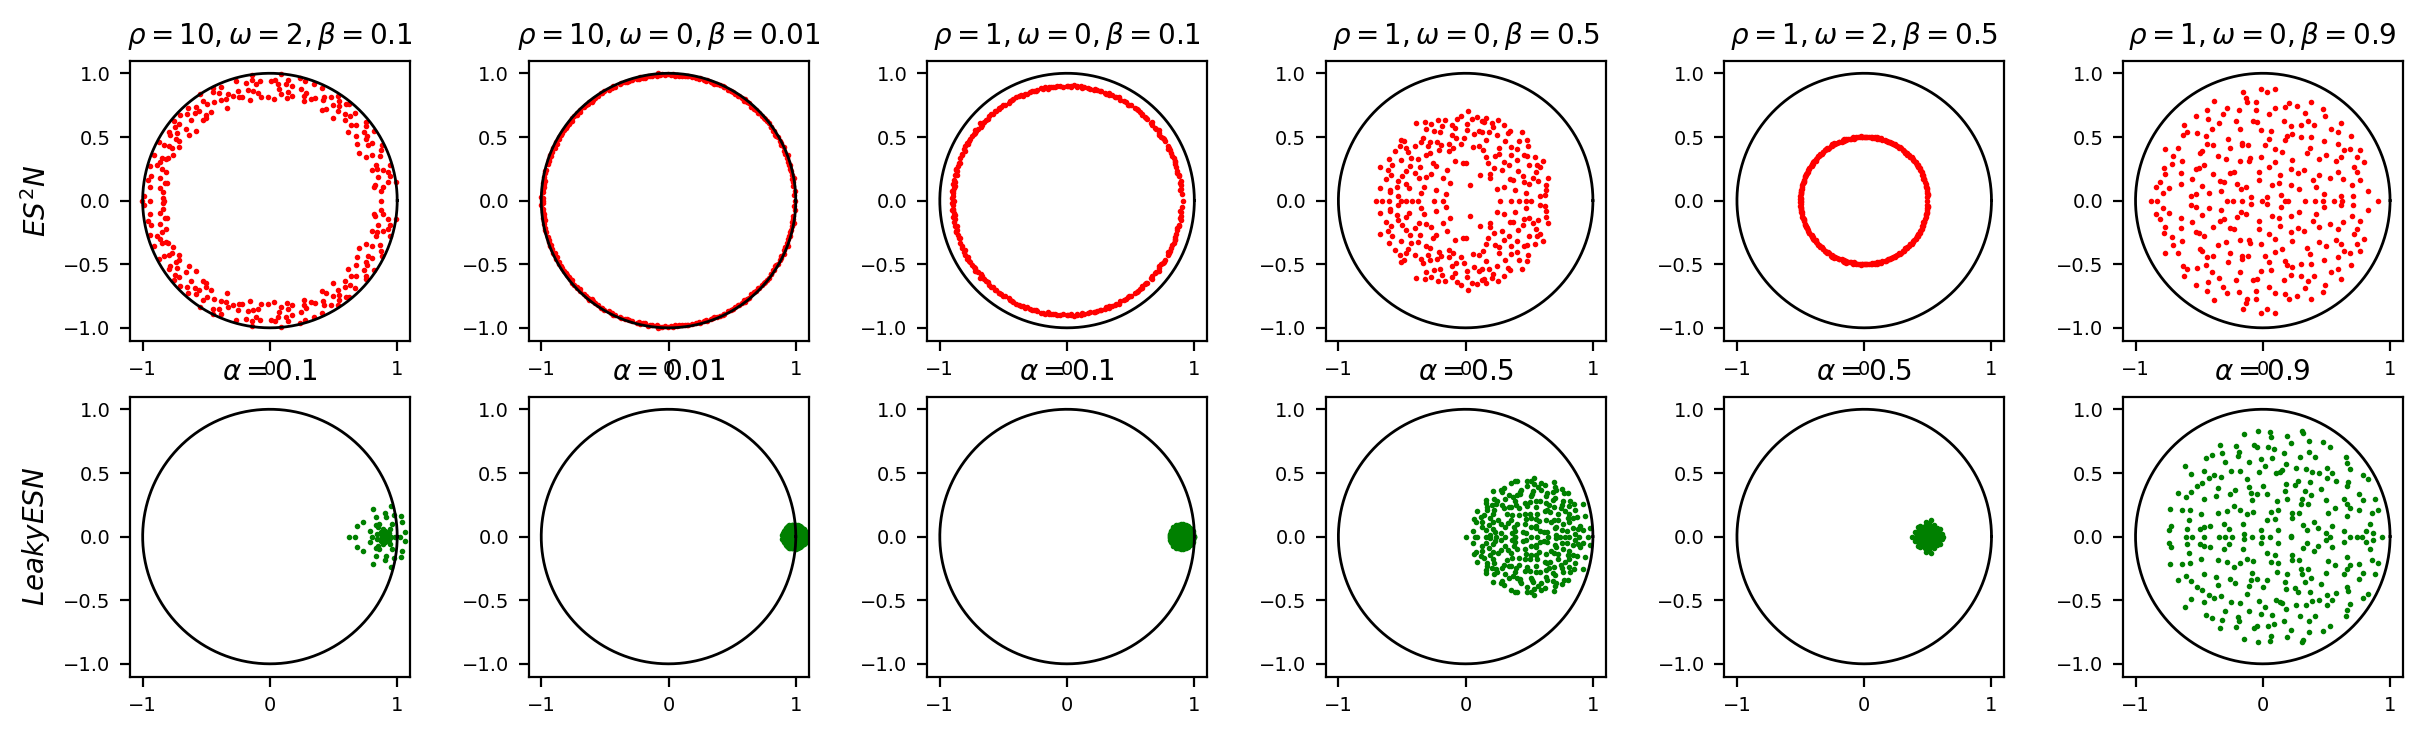

In [9]:
# Visualization of the eigenvalues
units = 300
configs = [
    (10, 2, 0.1 ),
    (10, 0, 0.01),
    (1,  0, 0.1 ),
    (1,  0, 0.5 ),
    (1,  2, 0.5 ),
    (1,  0, 0.9 ),
]
circle_x = np.cos(np.linspace(0, 2*np.pi, 1000))
circle_y = np.sin(np.linspace(0, 2*np.pi, 1000))

X = np.ones((2*units, 1))
x = np.ones((1, 1))

plt.figure(figsize=(15, 4), dpi=200)

plt.subplot(2, 6, 1, aspect="equal")
plt.ylabel("$ES^2N$", fontsize=10)
# Upper row (ES2N)
for i, (rho, omega, beta) in enumerate(configs):
    es2n = ES2N(units, input_scaling=omega, proximity=beta, sr=rho)
    es2n.run(X)
    J = jacobian(es2n, x, es2n.state())
    vals, _ = np.linalg.eig(J)

    plt.subplot(2, 6, i+1, aspect="equal")
    plt.title(f"$\\rho = {rho}, \\omega = {omega}, \\beta = {beta}$", fontsize=10)
    plt.scatter(vals.real, vals.imag, s=1, color="red")
    plt.plot(circle_x, circle_y, color="black", linewidth=1)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)


plt.subplot(2, 6, 7, aspect="equal")
plt.ylabel("$Leaky ESN$", fontsize=10)
# Lower row (LeakyESN)
for i, (rho, omega, alpha) in enumerate(configs):
    es2n = ES2N(units, input_scaling=omega, proximity=alpha, sr=rho, O=np.eye(units))
    es2n.run(X)
    J = jacobian(es2n, x, es2n.state())
    vals, _ = np.linalg.eig(J)

    plt.subplot(2, 6, i+7, aspect="equal")
    plt.title(f"$\\alpha = {alpha}$", fontsize=10)
    plt.scatter(vals.real, vals.imag, s=1, color="green")
    plt.plot(circle_x, circle_y, color="black", linewidth=1)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

plt.show()


## Memory capacity

In this section, we evaluate the memory capacity of the ES2N model. The memory capacity tasks consists in reproducing the input signal $u$ with a delay of $k$ ($u[t - k]$).

The memory capacity of a model with the timeseries $u$ and a delay of $k$ is defined as :
$$MC_k = r(y_k[t], u[t - k])^2$$
where $r$ denotes the Pearson correlation coefficient.

The MC score is defined as the sum over all $k$:
$$MC = \sum_{k=1}^{\infty} MC_k$$

In [8]:
# Task definition
rng = np.random.default_rng(seed=2504)
series = rng.uniform(low=-0.8, high=0.8, size=(6000, 1))

In [9]:
# Similar to the ReservoirPy method reservoirpy.datasets.to_forecasting, but in the other way: input X is ahead of output Y.
def to_postcasting(k=1):
    if k == 0:
        return series[:-1000], series[-1000:], series[:-1000], series[-1000:]
    X_train, X_test, shifted_train, shifted_test = to_forecasting(series, forecast=k, test_size=1000)
    return shifted_train, shifted_test, X_train, X_test

# kth memory capacity (MC_k) as defined in (Jaeger, 2002)
def kth_memory_capacity(k=1, model=None):
    # Dataset
    X_train, X_test, Y_train, Y_test = to_postcasting(k=k)
    # Model
    if model is None:
        model = ES2N(100, input_scaling=1., proximity=0.1, sr=1.) >> Ridge(ridge=1e-5)
    # Fit and run
    model.fit(X_train, Y_train, warmup=100)
    Y_pred = model.run(X_test)
    # u[t-k] - z_k[t] square correlation
    return np.square(np.corrcoef(Y_pred, Y_test, rowvar=False)[1, 0])

In [10]:
# Faster method : compute all memory capacities all at once
from numpy.lib.stride_tricks import sliding_window_view

def memory_capacity(k=200, model=None):
    # Dataset definition

    # sliding_window_view creates a matrix of the same
    # timeseries with an incremental shift on each column
    dataset = sliding_window_view(series[:, 0], k)[:, ::-1]
    X_train = dataset[:-1000, :1]
    X_test = dataset[-1000:, :1]
    Y_train = dataset[:-1000, 1:]
    Y_test = dataset[-1000:, 1:]
    # Model
    if model is None:
        model = ES2N(100, input_scaling=1., proximity=0.1, sr=1.) >> Ridge(ridge=1e-5)
    # Fit and run
    model.fit(X_train, Y_train, warmup=k)
    Y_pred = model.run(X_test)

    # u[t-k] - z_k[t] square correlation
    capacities = np.square([np.corrcoef(y_pred, y_test, rowvar=False)[1, 0] for y_pred, y_test in zip(Y_pred.T, Y_test.T)])
    return capacities

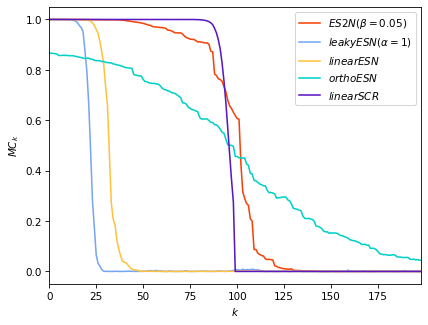

ES2N memory capacity: 98.20188033749459
linearESN memory capacity: 32.47316811402375
orthoESN memory capacity: 92.99515631570948
linearSCR memory capacity: 95.5846543343764


In [11]:
from reservoirpy.activationsfunc import identity
proximity = 0.05

mc_ES2N = memory_capacity(
    k = 200, 
    model= ES2N(100, sr=.9, proximity=proximity, input_scaling=0.1) >> Ridge(ridge=1e-7)
)

mc_ESN = memory_capacity(
    k = 200, 
    model= Reservoir(100, sr=.9, lr=1., input_scaling=0.1) >> Ridge(ridge=1e-7)
)

mc_linearESN = memory_capacity(
    k=200, 
    model= Reservoir(100, sr=.9, input_scaling=0.1, input_bias=False, lr=1, activation=identity) >> Ridge(ridge=1e-7)
)

mc_orthoESN = memory_capacity(
    k=200, 
    model= Reservoir(W=random_orthogonal(units=100, seed=rng), sr=.9, input_scaling=0.1, input_bias=False, lr=1) >> Ridge(ridge=1e-7)
)

def ring_matrix(units):
    return np.roll(np.eye(units), shift=1, axis=0)

mc_linearSCR = memory_capacity(
    k=200, 
    model= Reservoir(W=0.9*ring_matrix(units=100), input_connectivity=0.01, input_scaling=0.1, input_bias=False, lr=1., activation=identity) >> Ridge(ridge=1e-7)
)

plt.figure()
plt.plot(mc_ES2N, label=f"$ES2N (\\beta={proximity})$")
plt.plot(mc_ESN, label="$leaky ESN (\\alpha=1)$")
plt.plot(mc_linearESN, label="$linearESN$")
plt.plot(mc_orthoESN, label="$orthoESN$")
plt.plot(mc_linearSCR, label="$linearSCR$")
plt.xlabel("$k$")
plt.ylabel("$MC_k$")
plt.legend()
plt.show()

print(f"ES2N memory capacity: {np.sum(mc_ES2N)}")
print(f"linearESN memory capacity: {np.sum(mc_linearESN)}")
print(f"orthoESN memory capacity: {np.sum(mc_orthoESN)}")
print(f"linearSCR memory capacity: {np.sum(mc_linearSCR)}")

100%|██████████| 50/50 [32:13<00:00, 38.66s/it]


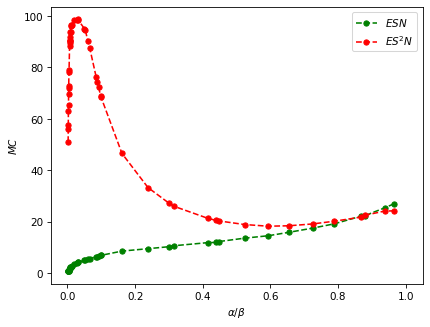

In [13]:
import tqdm
rng = np.random.default_rng(seed=2504)

a = rng.uniform(0.1, 1, (50, ))
s = rng.integers(0, 3, 50).astype(np.float64)

values = np.sort(a * np.power(10, -s))

esn_mc = np.zeros((50, 10))
es2n_mc = np.zeros((50, 10))

for i, value in enumerate(tqdm.tqdm(values)):
    for instance in range(10):
        esn = Reservoir(500, sr=.9, input_scaling=0.1, lr=value) >> Ridge(ridge=1e-5)
        esn_mc[i, instance] = np.sum(memory_capacity(k=200, model=esn))

        es2n = ES2N(100, sr=.9, input_scaling=0.1, proximity=value) >> Ridge(ridge=1e-5)
        es2n_mc[i, instance] = np.sum(memory_capacity(k=200, model=es2n))


plt.figure()
plt.plot(values, np.mean(esn_mc, axis=1), ".--", color="green", markersize=10, label="$ESN$")
plt.plot(values, np.mean(es2n_mc, axis=1), ".--", color="red", markersize=10, label="$ES^2N$")
plt.xlabel("$\\alpha / \\beta$")
plt.ylabel("$MC$")
plt.legend()
plt.xlim(-0.05, 1.05)
plt.show()